In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import clustering_based_anomaly_detection as clustering
import GMM_based_anomaly_detection as gmm
import sketch_based_anomaly_detection as sketch
import simple_classifier_utils
import utilies
from IPython.display import HTML, display
from tabulate import tabulate

Загружаем тестовые данные. В данном примере были отобраны тестовые данные трафика netflow за неделю.

In [2]:
ES_DATA_PATH = 'dataset/'
ES_DATA_FILE = '2022-04-06_day'
df = pd.read_csv(ES_DATA_PATH + ES_DATA_FILE + '.csv', index_col=0)
private_ip_set = utilies.get_private_ips(df)
df.timestamp = pd.to_datetime(df.timestamp)

Пример формата входных данных:

In [3]:
df.head()

,timestamp,in_bytes,ipv4_src,ipv4_dst,in_pkts,l4_src_port,l4_dst_port,ip_protocol_version,protocol
0,2022-04-06 00:00:00+00:00,636,92.50.154.90,224.0.0.252,12,64635,5355,4,17
1,2022-04-06 00:00:00+00:00,13227,10.0.109.16,10.0.26.100,65,50416,389,4,6
2,2022-04-06 00:00:00+00:00,17983,10.0.109.1,10.0.109.184,34,55777,56522,4,17
3,2022-04-06 00:00:00+00:00,33493,10.0.109.75,10.0.109.1,72,51850,55777,4,17
4,2022-04-06 00:00:00+00:00,108,10.0.109.152,91.244.183.103,1,55777,55777,4,17


Количество данных:

In [4]:
len(df)

4701867

# Поиск аномалий

Поиск аномалий алгоритмом DBSCAN - пространственная кластеризация, входные данные - количество трафика

In [5]:
%%time
eps = 10
min_samples = 20
strategy='concatenate'
DBSCAN_series = clustering.process_data(df, private_ip_set, strategy, eps, min_samples)

CPU times: total: 8.73 s
Wall time: 8.74 s


In [6]:
utilies.print_anomalies(DBSCAN_series)

Anomalies: 64 Aggregated by hour data: 4176


0,2022-04-06,0,10.0.159.5
1,2022-04-06,0,10.0.109.1
2,2022-04-06,0,10.0.109.16
3,2022-04-06,1,10.0.159.5
4,2022-04-06,1,10.0.109.1
5,2022-04-06,1,10.0.109.16
6,2022-04-06,2,10.0.159.5
7,2022-04-06,2,10.0.109.1
8,2022-04-06,2,10.0.109.16
9,2022-04-06,3,10.0.159.5
10,2022-04-06,3,10.0.109.1


Unique IPs: 5
10.0.109.1
10.0.159.5
10.0.109.16
10.0.109.50
10.0.109.125


Поиск аномалий алгоритмом LOF - локальный уровень выброса (по-сути K-mins), входные данные - количество трафика

In [7]:
%%time
n_neighbors = len(df) / 10
LOF_series = simple_classifier_utils.process_data(df, n_neighbors)

CPU times: total: 8.97 s
Wall time: 8.97 s


In [8]:
utilies.print_anomalies(LOF_series)

Anomalies: 1037 Aggregated by hour data: 4176


0,2022-04-06,0,10.0.109.101
1,2022-04-06,0,10.0.109.103
2,2022-04-06,0,10.0.109.105
3,2022-04-06,0,10.0.109.106
4,2022-04-06,0,10.0.109.109
5,2022-04-06,0,10.0.109.114
6,2022-04-06,0,10.0.109.119
7,2022-04-06,0,10.0.109.133
8,2022-04-06,0,10.0.109.135
9,2022-04-06,0,10.0.109.163
10,2022-04-06,0,10.0.109.171


Unique IPs: 133
10.0.109.81
192.168.20.2
10.0.109.188
10.0.109.40
10.0.7.36
10.0.109.119
10.0.109.171
10.0.109.89
10.0.109.50
10.0.109.9
10.0.109.36
10.0.109.157
10.0.109.176
10.0.109.60
10.0.109.43
10.0.109.145
10.0.109.206
10.0.109.63
10.0.109.99
10.0.109.207
10.0.109.109
10.0.109.118
10.0.109.121
10.0.109.162
10.0.109.59
10.0.109.123
10.0.159.5
10.0.109.61
10.0.109.210
10.0.116.5
10.0.109.122
10.0.109.137
10.0.109.169
10.0.109.115
10.0.109.186
10.0.109.150
10.0.109.39
10.0.109.205
10.0.109.52
10.0.109.149
10.0.109.116
10.0.109.67
10.0.109.108
10.0.109.161
10.0.109.62
10.0.109.41
10.0.109.164
10.0.109.204
10.0.109.71
10.0.109.130
10.0.26.101
10.0.109.66
10.0.109.182
10.0.7.61
10.0.109.153
10.0.4.70
10.0.109.76
10.0.109.113
10.0.109.187
10.0.109.185
10.0.109.174
10.0.109.166
10.0.109.2
10.0.109.172
10.0.109.167
10.0.109.189
10.0.109.105
10.0.109.146
10.0.109.175
10.0.109.70
10.0.109.132
10.0.109.143
10.0.109.101
10.0.109.1
10.0.109.72
10.0.106.5
10.0.109.79
10.0.109.127
10.0.109.69
10

Поиск аномалий с помощью модели смешанного гауссова узла GMM:

In [9]:
%%time
n_components = 1
n_init = 100
random_state = 40
treshold = 3
strategy='concatenate'
gmm_series = gmm.process_data(df, private_ip_set, strategy, treshold, n_components, n_init, random_state)

CPU times: total: 2min 3s
Wall time: 18.5 s


In [10]:
utilies.print_anomalies(gmm_series)

Anomalies: 216 Aggregated by hour data: 4176


0,2022-04-06,0,192.168.20.2
1,2022-04-06,0,10.0.109.99
2,2022-04-06,0,10.0.159.5
3,2022-04-06,0,10.0.109.205
4,2022-04-06,0,10.0.109.204
5,2022-04-06,0,10.0.109.1
6,2022-04-06,0,10.0.109.203
7,2022-04-06,0,10.0.109.58
8,2022-04-06,0,10.0.109.16
9,2022-04-06,1,192.168.20.2
10,2022-04-06,1,10.0.109.99


Unique IPs: 32
10.0.109.205
10.0.109.116
192.168.20.2
10.0.109.203
10.0.109.108
10.0.109.175
10.0.109.161
10.0.109.132
10.0.109.204
10.0.109.1
10.0.109.183
10.0.109.71
10.0.109.79
10.0.109.29
10.0.109.144
10.0.109.50
10.0.109.60
10.0.109.85
10.0.109.75
10.0.109.99
10.0.109.58
10.0.109.53
10.0.109.16
10.0.109.160
10.0.109.59
10.0.109.83
10.0.109.187
10.0.159.5
10.0.109.179
10.0.109.191
10.0.109.177
10.0.109.125


# Результат работы ансамбля алгоритмов

DBSCAN + LOF:

In [16]:
utilies.print_anomalies(DBSCAN_series, LOF_series)

Anomalies: 8 Aggregated by hour data: 8352


C:\Users\osenenko.ale\Documents\Projects\NetFlow\utilies.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x = x * args[0]


0,2022-04-06,0,10.0.159.5
1,2022-04-06,0,10.0.159.5
2,2022-04-06,4,10.0.109.1
3,2022-04-06,4,10.0.109.1
4,2022-04-06,4,10.0.109.50
5,2022-04-06,4,10.0.109.50
6,2022-04-06,16,10.0.159.5
7,2022-04-06,16,10.0.159.5


Unique IPs: 3
10.0.109.50
10.0.109.1
10.0.159.5


DBSCAN + GMM:

In [12]:
utilies.print_anomalies(DBSCAN_series, gmm_series)

Anomalies: 53 Aggregated by hour data: 4176


0,2022-04-06,0,10.0.159.5
1,2022-04-06,0,10.0.109.1
2,2022-04-06,0,10.0.109.16
3,2022-04-06,1,10.0.109.1
4,2022-04-06,1,10.0.109.16
5,2022-04-06,2,10.0.159.5
6,2022-04-06,2,10.0.109.1
7,2022-04-06,2,10.0.109.16
8,2022-04-06,3,10.0.109.1
9,2022-04-06,3,10.0.109.125
10,2022-04-06,4,10.0.109.50


Unique IPs: 5
10.0.109.1
10.0.159.5
10.0.109.16
10.0.109.50
10.0.109.125


LOF + GMM:

In [13]:
utilies.print_anomalies(LOF_series, gmm_series)

Anomalies: 144 Aggregated by hour data: 8352


C:\Users\osenenko.ale\Documents\Projects\NetFlow\utilies.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x = x * args[0]


0,2022-04-06,0,10.0.109.203
1,2022-04-06,0,10.0.109.203
2,2022-04-06,0,10.0.109.205
3,2022-04-06,0,10.0.109.205
4,2022-04-06,0,10.0.159.5
5,2022-04-06,0,10.0.159.5
6,2022-04-06,1,10.0.109.203
7,2022-04-06,1,10.0.109.203
8,2022-04-06,1,10.0.109.204
9,2022-04-06,1,10.0.109.204
10,2022-04-06,1,10.0.109.205


Unique IPs: 26
10.0.109.205
10.0.109.116
192.168.20.2
10.0.109.203
10.0.109.108
10.0.109.175
10.0.109.161
10.0.109.132
10.0.109.204
10.0.109.1
10.0.109.71
10.0.109.79
10.0.109.29
10.0.109.144
10.0.109.50
10.0.109.60
10.0.109.85
10.0.109.75
10.0.109.58
10.0.109.53
10.0.109.83
10.0.109.187
10.0.159.5
10.0.109.179
10.0.109.191
10.0.109.125


Визуализация аномалий алгоритма DBSCAN трафика за неделю с помощью t-SNE ( t-распределенное стохастическое соседнее вложение для неаномального и аномального трафика):

anomalies: ['10.0.159.5' '10.0.109.1' '10.0.109.16' '10.0.109.125']


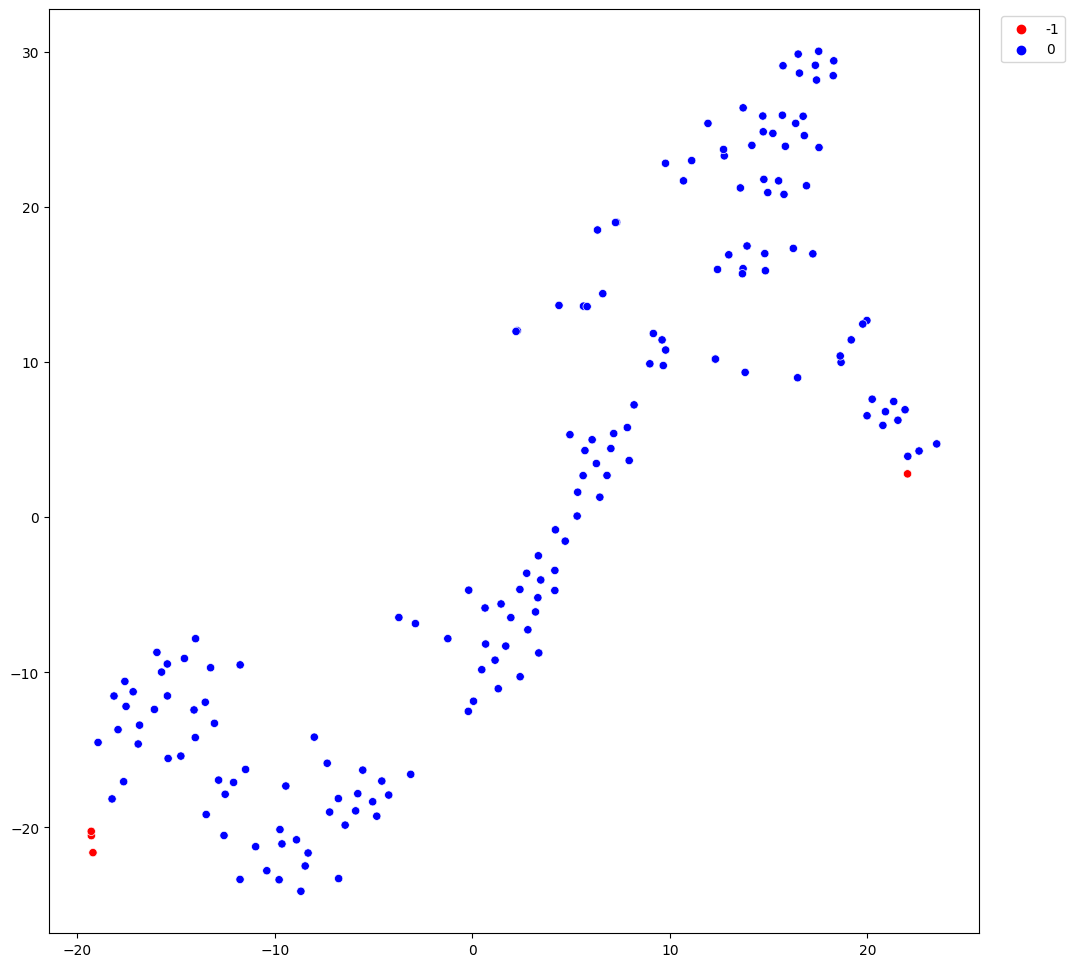

In [15]:
clustering.tsne_visualization(df, private_ip_set, strategy='concatenate', eps=5, min_samples=10)